<a href="https://colab.research.google.com/github/DrZubi/MIDS_DATASCI_207/blob/Priya/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# :Facial Expression Recognition - CNN:

#### ``Objective``
Implement a CNN to detect each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

#### ``Motivation``


#### ``Description``
Convolutional Neural Networks (CNNs) are a class of deep learning models particularly suited for processing structured grid-like data, such as images and videos. They are designed to automatically and adaptively learn spatial hierarchies of features through a series of convolutional layers. Each layer consists of filters that convolve over input data, capturing local patterns and features. CNNs are widely used in tasks such as image classification, object detection, and facial recognition due to their ability to effectively handle spatial relationships and hierarchical patterns within data.

#### ``Data``
In this assignment you will use a dataset for categorizing emtion through facial expression. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories.

- 0=Angry
- 1=Disgust
- 2=Fear
- 3=Happy
- 4=Sad
- 5=Surprise
- 6=Neutral


we will build and train a CNN model to predict the facial expression. The dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

#### ``Authors``
Serah Almeyda, Priya Iragavarapu, Francesca Scipioni, Sowjanya Yaddanapudi, Omar Zu'bi


---
### Step 1: Import libraries

In [2]:
# Standard Imports
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import import_ipynb

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.utils import resample

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras_tuner as kt

# Custom user defined imports
#from camera_feed import live_feed

# Inline and set seeds
%matplotlib inline
np.random.seed(0)
tf.random.set_seed(1234)

In [1]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


---
### Step 2: Data ingestion

Let's load the dataset and understand the shape, columns and unique emotions from the dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# FILL IN CODE HERE #
file_path = '/content/drive/MyDrive/Colab Notebooks/Data_ML_Project/icml_face_data.csv' # replace with your path
df = pd.read_csv(file_path)

Mounted at /content/drive


In [4]:
# Print the shape of the dataset
print('Dataset size:', df.shape)

# Print unique emotions
print('Unique emotions:', np.sort(df.emotion.unique()))

# Print the first five rows of the dataframe
df.head()

Dataset size: (35887, 3)
Unique emotions: [0 1 2 3 4 5 6]


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


There are 35,887 images corrresponding to 6 different facial expression categories:

In [5]:
# Column name corrections
df.columns = df.columns.str.lower().str.replace(' ', '')

# Function to convert pixel strings to numpy array
def string_to_array(string):
    '''Split pixles by space value and convert to numpy'''
    return np.array(string.split(), dtype='float32').reshape(48, 48)

# Apply pixel conversions
df['image'] = df['pixels'].apply(string_to_array)

# Create class mapping
emotion_mapping = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}

# Apply Mapping
df['emotion_label'] = df['emotion'].map(emotion_mapping)

---
### Step 3: Exploratory Data Analysis (EDA)

- Plot a histogram for the seven classes.
- Print 5 images from the data for each unique emotion.

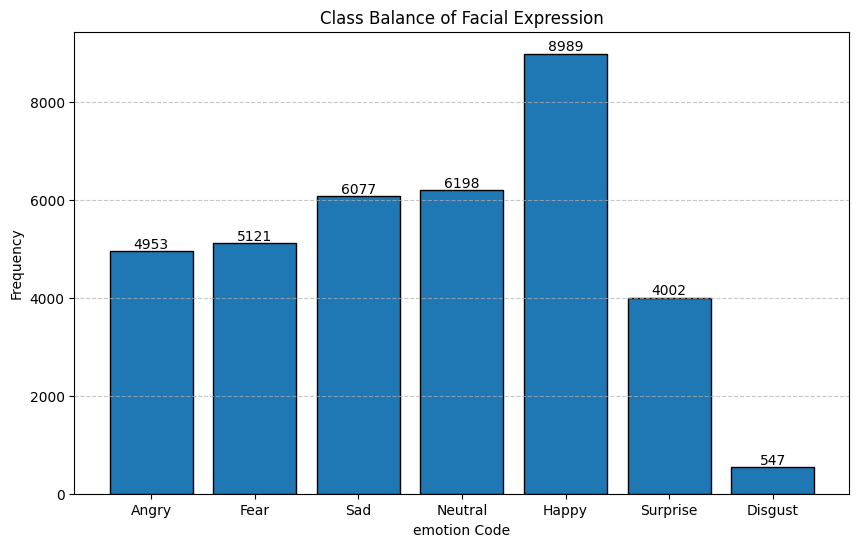

In [6]:
# Plot the histogram
plt.figure(figsize=(10, 6))
counts, bins, patches=plt.hist(df['emotion_label'], bins=np.arange(8) - 0.5, edgecolor='black', align='mid', rwidth=0.8)
plt.xlabel('emotion Code')
plt.ylabel('Frequency')
plt.title('Class Balance of Facial Expression')
plt.xticks(range(7))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, int(count), ha='center', va='bottom')


# Display the plot
plt.show()

There is a severe class imbalance between "Happy" (8989) and other classes with "Disgust" (547) being underrepresented.The "Happy" class is 16 times bigger than the "Digust" class.

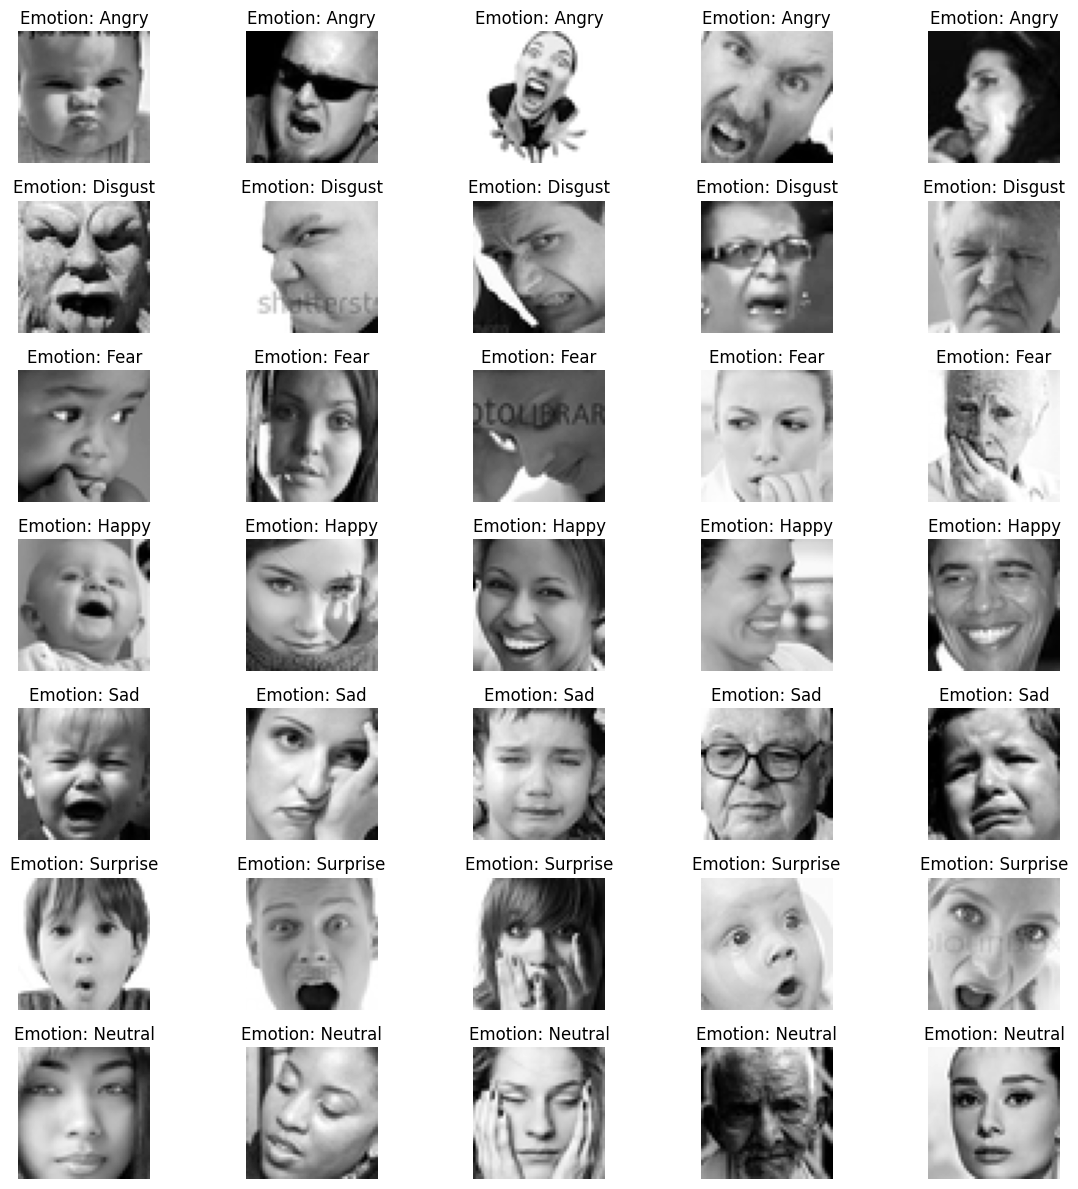

In [7]:
# Get unique emotion classes
emotion_classes = np.sort(df['emotion'].unique())

# Plot five images per emotion class
num_images_per_class = 5
fig, axes = plt.subplots(len(emotion_classes),
                         num_images_per_class,
                         figsize=(12, 12))

# Specify seed for consistent results
np.random.seed(0)

# Iterate through each emotion class and plot images
for i, emotion_class in enumerate(emotion_classes):

    # Select 5 random images from current emotion class
    images = df[df['emotion'] == emotion_class].sample(num_images_per_class)['image'].values

    # Image settings
    for j in range(num_images_per_class):
        axes[i, j].imshow(images[j], cmap='gray')
        axes[i, j].set_title(f'Emotion: {emotion_mapping[emotion_class]}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

The dataset holds 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image.

---
### Step 4: Data preprocessing

First, we will correct for class imbalance.The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance by undersampling the smallest class size.

In [8]:
# Identify the size of the smallest class
max_size = df['emotion'].value_counts().max()

# oversample each class to the size of the smallest class
df_balanced = df.groupby('emotion').apply(lambda x: resample(x, replace=True, n_samples=max_size, random_state=42)).reset_index(drop=True)

# Check the new class distribution
print(df_balanced['emotion'].value_counts())

emotion
0    8989
1    8989
2    8989
3    8989
4    8989
5    8989
6    8989
Name: count, dtype: int64


#### Test Train Split

Create train, validation, and test data. We will follow the below steps to split the data.

1. Normalize the values in the image column

2. shuffle images before splitting the data

3. use a (0.6,0.2,0.2)train/validation/test set split

4. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [9]:
def transform_split(images, labels, splits):
    """Split data into train, validation, and test sets; apply transformations and augmentations

    Args:
    images (np.ndarray): Images of shape (N, 48, 48, 1)
    labels (np.ndarray): Labels of shape (N,)
    splits (tuple): 3 values summing to 1 defining split of train, validation, and test sets

    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 48, 48, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 48, 48, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 48, 48, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    """

    # Normalize images to [0, 1] range and ensure numpy array type
    images = (images / 255.0).to_numpy()
    labels = labels.to_numpy()

    # Shuffle data
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # Create data splits (training, val, and test sets)
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size = 1 - splits[0], random_state=1234, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=splits[2] / (splits[1] + splits[2]), random_state=1234, stratify=y_temp)

    # Reshape the X_train and X_test data to (48, 48, 1)
    X_train = [i.reshape(48, 48, 1) for i in X_train]
    X_test = [i.reshape(48, 48, 1) for i in X_test]
    X_val = [i.reshape(48, 48, 1) for i in X_val]

    # Ensure numpy array
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_val = np.array(X_val)

    # Print shapes
    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_val shape:', X_val.shape)
    print('y_val shape:', y_val.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# Define train, val, test splits
split = (0.6, 0.2, 0.2)

# Create train test split with augmented data
X_train, y_train, X_val, y_val, X_test, y_test = transform_split(
    df_balanced['image'],
    df_balanced['emotion'],
    split
)

X_train shape: (37753, 48, 48, 1)
y_train shape: (37753,)
X_val shape: (12585, 48, 48, 1)
y_val shape: (12585,)
X_test shape: (12585, 48, 48, 1)
y_test shape: (12585,)


---
### Step 5: Modeling

The objective is to build and train a CNN model to identify the facial expressions based on the emotion. we will implement a CNN classifier according to the following guidelines (let's call this model1; this model will serve as our baseline classifier):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 48 x 48 x 1 (that is, the images are on a single gray scale)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size (filter sizes) = (3 x 3)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. we will add early stopping i.e. pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]".

### Baseline Model

In [11]:
def create_CNN(n_classes = 10,
               neurons = 128,
               dropout_rate = 0.3,
               num_filters = [12],
               filter_sizes = [(3,3)],
               maxpools = [(2, 2)],
               activation = 'relu',
               optimizer = 'adam',
               learning_rate = 0.001,
               metrics = ['accuracy'],
               conv_layers = 1):
    """
    Create a Convolutional Neural Network (CNN) model for image classification (48x48x1).

    Parameters:
    -----------
    n_classes : int
        Number of classes in the classification task.

    neurons : int
        Number of neurons in the fully connected dense layer.

    dropout_rate : float
        Dropout rate to prevent overfitting.

    num_filters : list of int
        List of integers specifying the number of filters for each Conv2D layer.

    filter_sizes : list of tuples
        List of tuples specifying the size of filters (height, width) for each Conv2D layer.

    maxpools : list of tuples
        List of tuples specifying the size of max pooling windows (height, width) for each MaxPooling2D layer.

    activation : str
        Activation function to use in Conv2D and Dense layers.

    optimizer : str or tf.keras.optimizers.Optimizer
        Optimizer to use for training the model.

    learning_rate : float
        Learning rate for the optimizer.

    metrics : list of str
        List of metrics to evaluate during training and testing.

    conv_layers : int
        Number of convolutional layers to include in the CNN architecture.

    Returns:
    --------
    model : tf.keras.models.Sequential
        Compiled CNN model ready for training.
    """

    '''Clear session'''
    tf.keras.backend.clear_session()

    '''Define Early Stopping Case'''
    # define an instance of the early_stopping class
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy for early stopping
        verbose=0,
        patience=4,
        mode='max',
        restore_best_weights=True)

    # Validate input parameters
    if not isinstance(num_filters, list) or not isinstance(filter_sizes, list) or not isinstance(maxpools, list):
        raise ValueError("num_filters, filter_sizes, and maxpools must be lists.")

    if len(num_filters) != conv_layers or len(filter_sizes) != conv_layers or len(maxpools) != conv_layers:
        raise ValueError("Lengths of num_filters, filter_sizes, and maxpools must match conv_layers.")

    '''Build CNN based on user inputs'''
    model = Sequential()

    # Go through each layer input
    for i in range(conv_layers):
        # Conv2D Settings
        model.add(Conv2D(filters = num_filters[i],
                         kernel_size = filter_sizes[i],
                         strides = (1,1),
                         padding = 'same',
                         data_format = 'channels_last',
                         activation = activation,
                         input_shape=(48, 48, 1) if i == 0 else None))  # For initial layer only

        # MaxPooling settings
        model.add(MaxPooling2D(maxpools[i]))

    # Output layer
    model.add(tf.keras.layers.Flatten())  # Flatten
    model.add(Dense(neurons, activation=activation))  # Train on neurons
    model.add(Dropout(dropout_rate))  # Drop % to prevent overfitting
    model.add(Dense(n_classes, activation='softmax'))  # Specify number of outputs

    '''Compile model'''
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    # Return statement
    return model

In [12]:
# Create model using default settings
baseline_model = create_CNN()

# Print model summary
baseline_model.summary()

# Train model for testing purposes
history = baseline_model.fit(X_train, y_train,
                   epochs = 20,
                   batch_size = 32,
                   validation_data = (X_val, y_val),
                   verbose = 0)


# Evaluate the accuracy of model1 on (X_train, y_train) and (X_val, y_val)
train_loss, train_accuracy = baseline_model.evaluate(X_train, y_train)
val_loss, val_accuracy = baseline_model.evaluate(X_val, y_val)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 12)        120       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 12)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6912)              0         
                                                                 
 dense (Dense)               (None, 128)               884864    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [ ]:
# This is my hyperparameter tuning code

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, n_classes):
        self.input_shape = input_shape
        self.n_classes = n_classes

    def build(self, hp):
        model = Sequential()

        # First Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001),
            input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_1_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Second Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_2_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Third Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_3_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_3_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Flatten layer
        model.add(Flatten())

        # Dense layer
        model.add(Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(Dropout(hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(self.n_classes, activation='softmax'))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

# Hyperparameter tuning setup
input_shape = (48, 48, 1)
n_classes = 10
hypermodel = CNNHyperModel(input_shape, n_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cnn_tuning')

# Assuming X_train, y_train, X_val, y_val are already defined
tuner.search_space_summary()
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = hypermodel.build(best_hps)
model.summary()

# Train the final model
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Evaluate the accuracy of the final model on (X_train, y_train), (X_val, y_val), and (X_test, y_test)
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")


Trial 20 Complete [00h 05m 19s]
val_accuracy: 0.725069522857666

Best val_accuracy So Far: 0.847199022769928
Total elapsed time: 01h 02m 40s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 44, 44, 192)       4992      
                                                                 
 batch_normalization_3 (Bat  (None, 44, 44, 192)       768       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 192)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 192)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 1

In [13]:
# Define model_path with a valid file extension (.keras or .h5)
model_path = '/content/drive/MyDrive/Colab Notebooks/Data_ML_Project/baseline_model.h5'

# Save the entire model to the specified path
baseline_model.save(model_path)

# Load the saved model and verify it's correctly saved
try:
    loaded_model = load_model(model_path)
except FileNotFoundError:
    print(f"Error: Model file '{model_path}' not found. Make sure the model is saved correctly.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Hyperparameter Optimization

In [14]:
# Define the model building function

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, n_classes):
        self.input_shape = input_shape
        self.n_classes = n_classes

    def build(self, hp):
        model = Sequential()

        # First Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001),
            input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_1_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Second Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_2_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Third Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_3_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_3_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Flatten layer
        model.add(Flatten())

        # Dense layer
        model.add(Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(Dropout(hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(self.n_classes, activation='softmax'))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

# Hyperparameter tuning setup
input_shape = (48, 48, 1)
n_classes = 10
hypermodel = CNNHyperModel(input_shape, n_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cnn_tuning')

# Assuming X_train, y_train, X_val, y_val are already defined
tuner.search_space_summary()
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = hypermodel.build(best_hps)
model.summary()

# Train the final model
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Evaluate the accuracy of the final model on (X_train, y_train), (X_val, y_val), and (X_test, y_test)
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")


Trial 20 Complete [00h 03m 19s]
val_accuracy: 0.5478744506835938

Best val_accuracy So Far: 0.8502979874610901
Total elapsed time: 00h 57m 53s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_3 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21,

In [15]:
# Define model_path with a valid file extension (.keras or .h5)
model_path = '/content/drive/MyDrive/Colab Notebooks/Data_ML_Project/tuned_model.h5'

# Save the entire model to the specified path
model.save(model_path)

# Load the saved model and verify it's correctly saved
try:
    loaded_model = load_model(model_path)
except FileNotFoundError:
    print(f"Error: Model file '{model_path}' not found. Make sure the model is saved correctly.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---
### Step 6: Evaluation

We will now use the test data to evaluate the performance (accuracy) on unseen data.

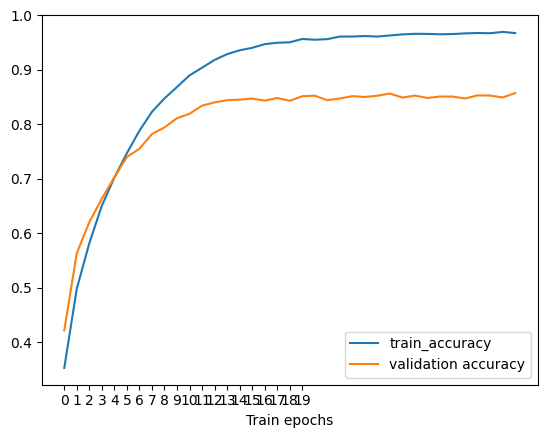

Training accuracy: 0.9677
Validation accuracy: 0.8575

Testing loss: 0.9196
Testing accuracy: 0.8604


In [16]:
# Functiont to compute training and validation accuracy
def compute_accuracy(model, history, X_train, y_train, X_test, y_test, epochs):
    '''
    Computes the training and validation accuracy after fitting, and evaluates the final testing accuracy.

    Parameters:
    -----------
    model: tf.keras.model
        The CNN model instance created and compiled after fitting.

    history: obj
        The history object returned from model.fit(), containing training metrics.

    X_train: numpy.ndarray
        Training dataset input.

    y_train: numpy.ndarray
        Training dataset labels.

    X_test: numpy.ndarray
        Testing dataset input.

    y_test: numpy.ndarray
        Testing dataset labels.

    epochs: int
        Number of epochs the model was trained for.
    '''

    # Get training and valudation accuracy of digits model
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    # Print last epoch results
    print('Training accuracy: %1.4f' % train_accuracy[-1])
    print('Validation accuracy: %1.4f' % val_accuracy[-1])

    # Evaluate testing results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('\nTesting loss: %1.4f' % test_loss)
    print('Testing accuracy: %1.4f' % test_acc)

# Comptue model accuracies
compute_accuracy(model, history, X_train, y_train , X_test, y_test, 20)


394/394 [==============================] - 1s 2ms/step


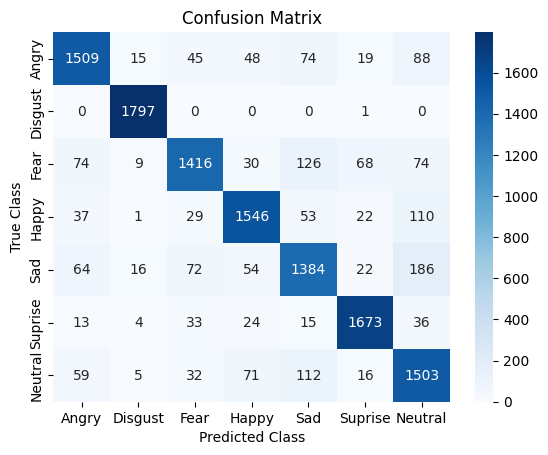

In [17]:
# Get testing dataset predictions and labels
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds_labels)

# Plot confusion matrix
emotions = ['Angry','Disgust','Fear','Happy','Sad','Suprise','Neutral']
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=emotions,
            yticklabels=emotions)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_3 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 256)       147712    
                                                                 
 batch_normalization_4 (Bat  (None, 21, 21, 256)      

----
### Step 7: Model Live Demo


In [ ]:
live_feed(model) # Type Q to exit out